In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

def get_data(path):
    with open(path, newline='\n') as csvfile:
        raw_data = [line for line in csv.reader(csvfile)]
        dataset = np.array(raw_data).astype(np.float)
        classes = {
            c: count for c, count in zip(
                *(np.unique(dataset.transpose()[2], return_counts=True))
            )
        }

        dataset_without_class = np.array([r[:-1] for r in dataset])
        
        print(f'Число признаков: {dataset_without_class.shape[1]}')
        print(f'Число классов: {len(classes)}')
        print(f'Объем выборки: {len(dataset)}')
        print(f'Объем выборки для каждого класса: {classes}')

        return dataset, dataset_without_class


dataset_raw, dataset = get_data("./data_lab3v03.csv")


Число признаков: 2
Число классов: 2
Объем выборки: 650
Объем выборки для каждого класса: {-1.0: 400, 1.0: 250}


============== оригинальный график ==============


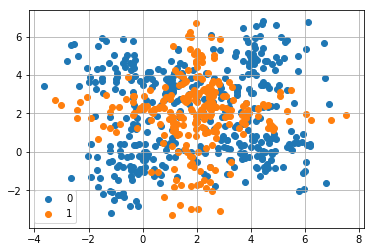

разбиение по классам: [234 156]
разбиение по классам: [126  69]
разбиение по классам: [40 25]
разбиение по классам: [400 250]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def build_dataset(dataset, learn_p=0.6, valid_p=0.3, test_p=0.1):
    data_rest = {tuple(data) for data in dataset}
    def subsample(x, x_rest=None, p=None):
        if x_rest:
            data = np.random.permutation(list(x_rest))[:int(len(x)*p)]
            x_rest -= set(tuple(d) for d in data)
        else:
            data = np.random.permutation(x)
        return {
            'data': np.array([d[:-1] for d in data]),
            'true': np.array([1 if d[-1] > 0 else 0 for d in data]),
        }
    full = subsample(dataset)
    learn = subsample(dataset, data_rest, learn_p)
    valid = subsample(dataset, data_rest, valid_p)
    test = subsample(dataset, data_rest, test_p)
    return learn, valid, test, full


def standartize(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    return scaler.transform(data_to_transform)

def show_graph(sample):
    print('============== оригинальный график ==============')
    points = [{
        'x': sample['data'][i][0],
        'y': sample['data'][i][1],
        'true': sample['true'][i],
    } for i in range(len(sample['true']))]

    points = {
        'true': {
            'x': [p['x'] for p in points if p['true']],
            'y': [p['y'] for p in points if p['true']],
        },
        'false': {
            'x': [p['x'] for p in points if not p['true']],
            'y': [p['y'] for p in points if not p['true']],
        }
    }

    fig, ax = plt.subplots()
    ax.scatter(points['false']['x'], points['false']['y'])
    ax.scatter(points['true']['x'], points['true']['y'])
    ax.legend(['0', '1'])
    plt.grid(True)
    plt.show()
    print('==========================================')

learn, valid, test, full = build_dataset(dataset_raw)
original_learn = learn['data']

show_graph(full)

for sample in (learn, valid, test, full):
    print(f"разбиение по классам: {np.unique(sample['true'], return_counts=True)[1]}")
    sample['data'] = standartize(original_learn, sample['data'])


In [3]:
import tensorflow as tf
# import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras import optimizers
from keras import losses
from keras.callbacks import EarlyStopping, Callback
from keras import backend as K

Using TensorFlow backend.


In [4]:
def post_prod(x):
    return [1 if i > 0.5 else 0 for i in x]

class TestGraph(Callback): 
    def __init__(self, test): 
        self.test = test

    def on_train_begin(self, logs={}): 
        self.test_loss = [] 
        self.test_acc = [] 

    def on_epoch_end(self, batch, logs={}): 
        loss, acc = self.model.evaluate(self.test['data'], self.test['true'], batch_size=len(self.test['data']), verbose=0, steps=None) 
        self.test_loss.append(loss) 
        self.test_acc.append(1 - acc)

In [5]:
classif = Sequential()

in_dim = np.shape(learn['data'])[1]

print(in_dim)


layer1count = 10
layer2count = 10
layer1AH = 'tanh'
layer2AH = 'tanh'

moment = 0.9

classif.add(Dense(layer1count, activation=layer1AH, input_dim=in_dim, kernel_initializer='he_normal'))
classif.add(Dense(layer2count, activation=layer2AH, kernel_initializer='he_normal'))
classif.add(Dense(1, activation='sigmoid'))

opti = optimizers.SGD(lr=0.001, momentum=moment, decay=0.0, nesterov=False)

classif.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
classif.build()

2
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
b_size = len(learn['data'])

f_predict_before = classif.predict(test['data'], batch_size=None, verbose=0, steps=None)

stop = EarlyStopping(monitor='val_loss', min_delta=0.000_001, patience=25_000, verbose=0, restore_best_weights=False)

test_graph = TestGraph(test)
history = classif.fit(
    learn['data'], learn['true'], batch_size=b_size, epochs=80_000, callbacks=[stop, test_graph],
    verbose=0, validation_data=(valid['data'], valid['true']), shuffle=False
)

Instructions for updating:
Use tf.cast instead.


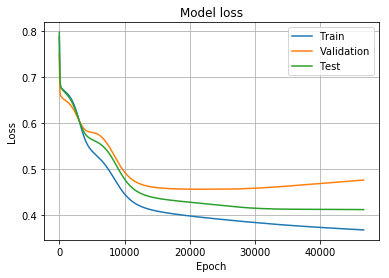

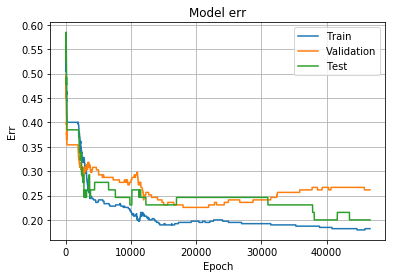

In [7]:
def show_loss(history, test_graph):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(test_graph.test_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
    plt.grid(True)
    plt.show()
    
def show_acc(history, test_graph):
    err = [1 - acc for acc in history.history['acc']]
    val_err = [1 - acc for acc in history.history['val_acc']]
    test_err = test_graph.test_acc
    plt.plot(err)
    plt.plot(val_err)
    plt.plot(test_err)
    plt.title('Model err')
    plt.ylabel('Err')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test'], loc='upper right')
    plt.grid(True)
    plt.show()

show_loss(history, test_graph)
show_acc(history, test_graph)

In [12]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    cmap = plt.get_cmap(cmap)
    
    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = np.array([1 if i > 0.5 else 0 for i in model.predict(np.c_[xx.ravel(), yy.ravel()])])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    plt.grid(True)
    plt.show()

============== оригинальный график ==============
пересечение: 139 из 650; 21.38%


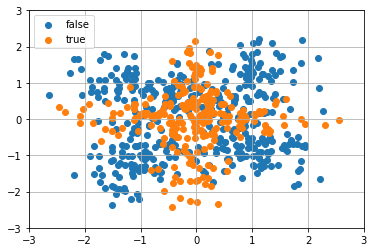

промахов на выборке learn: 0.18 | 0.37
============== точки промахов ==============


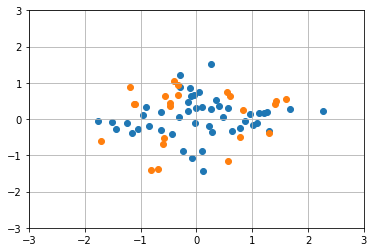

промахов на выборке test: 0.2 | 0.41
============== точки промахов ==============


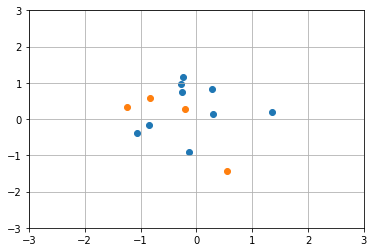

промахов на выборке valid: 0.26 | 0.48
============== точки промахов ==============


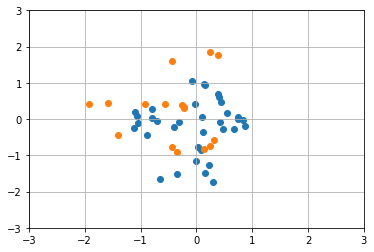

промахов на выборке full: 0.21 | 0.4
============== точки промахов ==============


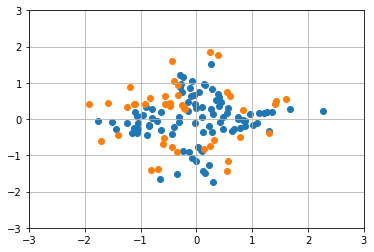

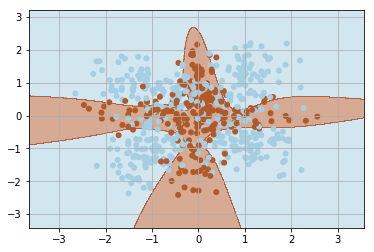

In [13]:
def count(iterable, f):
    return len([None for i in iterable if f(i)])

def check(pair):
    true, predict = pair
    return abs(true - predict) > 0.5

def show_graph(sample):
    print('============== оригинальный график ==============')
    points = [{
        'x': sample['data'][i][0],
        'y': sample['data'][i][1],
        'true': sample['true'][i],
    } for i in range(len(sample['true']))]

    points = {
        'true': {
            'x': [p['x'] for p in points if p['true']],
            'y': [p['y'] for p in points if p['true']],
        },
        'false': {
            'x': [p['x'] for p in points if not p['true']],
            'y': [p['y'] for p in points if not p['true']],
        }
    }

    def class_false_in_class_true(point):
        x, y = point
        return -0.5 < x < 0.5 or -0.5 < y < 0.5

    intersect = count(
        zip(points['false']['x'], points['false']['y']),
        class_false_in_class_true
    )
    print(f'пересечение: {intersect} из {len(sample["data"])}; {intersect/len(sample["data"]):.2%}')

    fig, ax = plt.subplots()
    ax.scatter(points['false']['x'], points['false']['y'])
    ax.scatter(points['true']['x'], points['true']['y'])
    ax.set_ylim((-3, 3))
    ax.set_xlim((-3, 3))
    ax.legend(['false', 'true'])
    plt.grid(True)
    plt.show()
    print('==========================================')
    
    

def show_mismatch(sample, label):
    bs = len(sample['data'])
    predict = classif.predict(sample['data'], batch_size=bs, verbose=0, steps=None)
    loss, acc = classif.evaluate(sample['data'], sample['true'], batch_size=bs, verbose=0, steps=None)
    print(f'промахов на выборке {label}: {1-acc:.2} | {loss:.2}')
    print('============== точки промахов ==============')
    mismatches_p = [{
        'x': sample['data'][i][0],
        'y': sample['data'][i][1],
        'true': sample['true'][i],
    } for i, z in enumerate(zip(sample['true'], predict)) if check(z)]

    mismatches_p = {
        'true': {
            'x': [p['x'] for p in mismatches_p if p['true']],
            'y': [p['y'] for p in mismatches_p if p['true']],
        },
        'false': {
            'x': [p['x'] for p in mismatches_p if not p['true']],
            'y': [p['y'] for p in mismatches_p if not p['true']],
        }
    }
    fig, ax = plt.subplots()
    ax.scatter(mismatches_p['false']['x'], mismatches_p['false']['y'])
    ax.scatter(mismatches_p['true']['x'], mismatches_p['true']['y'])
    ax.set_ylim((-3, 3))
    ax.set_xlim((-3, 3))
    plt.grid(True)
    plt.show()
    print('==========================================')
    
def square_range(x=[-3, 3], y=[-3, 3]):
    np.arange(my_range[0], my_range[1]+delta, delta)
          

          
show_graph(full)
show_mismatch(learn, 'learn')
show_mismatch(test, 'test')
show_mismatch(valid, 'valid')
show_mismatch(full, 'full')
          
plot_decision_boundary(full['data'], full['true'], classif)

In [10]:
from sklearn.metrics import confusion_matrix
def matrix(sample):
    bs = len(sample['data'])
    predict = post_prod(classif.predict(sample['data'], batch_size=bs, verbose=0, steps=None))
    return confusion_matrix(sample['true'], predict, labels=[1, ])

print(count(
    zip(learn['true'], post_prod(classif.predict(learn['data'], verbose=0, steps=None))),
    lambda x: x[0] != x[1]
), len(learn['true']))

print(matrix(learn))
print('===============')
print(f'matrix test\n{matrix(test)}')

71 390
[[133  23]
 [ 48 186]]
matrix test
[[21  4]
 [ 9 31]]
